# <span style="color:black">This notebook includes preliminary analysis and data exploration pipelines to preprocess the data.</span>

## <span style="color:black">Mount drive to notebook</span>

In [11]:
from google.colab import drive
drive._mount('/content/drive', force_remount=True)

Mounted at /content/drive


## <span style="color:black">Install needed packages</span>

In [12]:
# !pip install tld
# !pip install pandas==1.0.5

import os
import bz2
import json
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from utils import process_chunk, process_text, manual_extraction, ids_to_tweets, embedSentence, embedding, averageEmbedding, featurize

#Packages for url parsing
# import trt get_tld
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from urllib.request import urlopen
#Packages for dimentionality reduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize.treebank import TreebankWordDetokenizer
#Packages for NLP methods
import re
import nltk
import gensim
from gensim import models
from gensim import corpora
import gensim.downloader as api
from gensim.test.utils import datapath, common_texts
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
# We need this dataset in order to use the tokenizer
nltk.download('punkt')
# Also download the list of stopwords to filter out
nltk.download('stopwords')
stemmer = PorterStemmer()

# Add constants/paths
_DATASETS_PATHS = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <span style="color:Blue">1) Load Datasets</span>

In [ ]:
# Save the datasets paths
quote_datasets = sorted(glob.glob(_DATASETS_PATHS+'/Quotebank/*.bz2'))
quote_datasets

['/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2015.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2016.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2017.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2018.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2019.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2020.json.bz2']

### <span style="color:red"><div style="text-align: justify">In order to deal with extremely large data we decided chunking the data and apply all the processing and data wrangling steps on chunks then combine the chunk results (inspired by this [article](https://towardsdatascience.com/3-simple-ways-to-handle-large-data-with-pandas-d9164a3c02c1))</div></span>

In [ ]:
#Iterate through years dataset then create an iterator to process chunks of 1M rows at a time
num_quotes_per_year = {}
for dataset in quote_datasets:
    data_name = os.path.basename(dataset).split('-')[1]
    num_quotes_per_year[data_name] = 0
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', data_name)
    for chunk in df_reader:
        num_quotes_per_year[data_name] += len(chunk)
    print(f'About {num_quotes_per_year[data_name]} in {data_name}')

Processing Data: 2015.json.bz2
About 20874338 in 2015.json.bz2
Processing Data: 2016.json.bz2
About 13862129 in 2016.json.bz2
Processing Data: 2017.json.bz2
About 26611588 in 2017.json.bz2
Processing Data: 2018.json.bz2
About 27228451 in 2018.json.bz2
Processing Data: 2019.json.bz2
About 21763302 in 2019.json.bz2
Processing Data: 2020.json.bz2
About 5244449 in 2020.json.bz2


In [ ]:
with open('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/dict.json') as f:
  num_quotes_per_year = json.load(f)

In [ ]:
#Save dictionary as dataframe
dataset = {'year': [i.split('.')[0]for i in list(num_quotes_per_year.keys())],
           'num_quotes': list(num_quotes_per_year.values())}
df_quotes = pd.DataFrame(dataset)
df_quotes

,year,num_quotes
0,2015,20874338
1,2016,13862129
2,2017,26611588
3,2018,27228451
4,2019,21763302
5,2020,5244449


Text(0, 0.5, '# of Quotes')

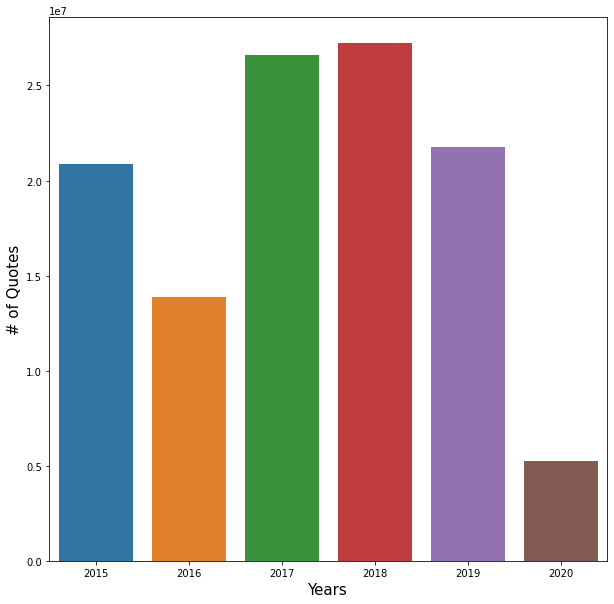

In [ ]:
#Visualize number of quotes per year
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = sns.barplot(x="year", y="num_quotes", data=df, capsize=.5, ax=axis)
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('# of Quotes', fontsize=15)

## <span style="color:Blue">2) Topic Analysis</span>

### <span style="color:Red"><div style="text-align: justify">After loading the data, we need to extract the targeted quotes from the dataset that will be used in our project. Thus, there are three methods to do so explained below.</div></span>

### <span style="color:Red"><div style="text-align: justify">In this phase we have investigated different ways to extract the quotes of interests (Manual, websites & NLP). However, we settled down with a specific pipeline which is illustrated below. Accordingly, all the efforts done are included in detail below but keep in mind that the final version used is the diagram below.</div></span>

![Diagram](https://drive.google.com/uc?export=view&id=1YhCxLciq4r2-hu6GEQlT9SfWA8zCS67Z)


### <span style="color:green">A- Manual Extraction Method</span>

#### <span style="color:purple"><div style="text-align: justify">This method is a naive one which means extracting the rows that their quotes include specific keywords. Accordingly, in order to compile a more thorough keywords, we investigated a couple of articles/papers concerning sexual harassement movements such as MeToo such as: [article 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6751092/)</div></span>

#### <span style="color:purple"><div style="text-align: justify"> Then, we decided to filter the dataset from 2015-2020 with one keyword (metoo) and from the resulted quotes we built a word cloud using [WordCloud Library](https://amueller.github.io/word_cloud/) to select the top 20 keywords mentioned in these quotes and pick the relevant ones. Also, we added keywords from this [website](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/2SRSKJ) and this [article](https://journals.sagepub.com/doi/10.1177/1940161220968081) to end up at the end with 15 keywords.</div></span>

In [ ]:
#Iterate through all datasets and extract the quotes containing metoo
for dataset in quote_datasets:
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', os.path.basename(dataset))
    for chunk in df_reader:
        chunk = process_chunk(chunk, manual_extraction, keywords_quotes_path)

#### <span style="color:purple"><div style="text-align: justify"> The results of the above cell is saved in the path mentioned below.</div></span>

In [ ]:
me_too_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/metoo-extracted-quotes.csv.bz2'

In [ ]:
#Load the saved results from previous cell
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv(me_too_quotes_path)
df.drop(df[df == 'quotation'].index)
df = df.drop(columns='Unnamed: 0')
print(f'The number of quotes that contain metoo: {len(df)}')
df.head(10)

The number of quotes that contain metoo: 1270


,quotation
0,This important study will help Eabametoong Fir...
1,The real #metoo video is finally up! Missed th...
2,Might have fell down... but I KILLLED that shI...
3,The real #metoo video is finally up! Missed th...
4,The real #metoo is finally up! Missed that bas...
5,The real #metoo video is finally up!
6,Might have fell down... but I KILLLED that [ e...
7,We're shocked by @stassi's comments re the #me...
8,"The #metoo movement is growing daily, as high-..."
9,When people like me are wrongfully accused by ...


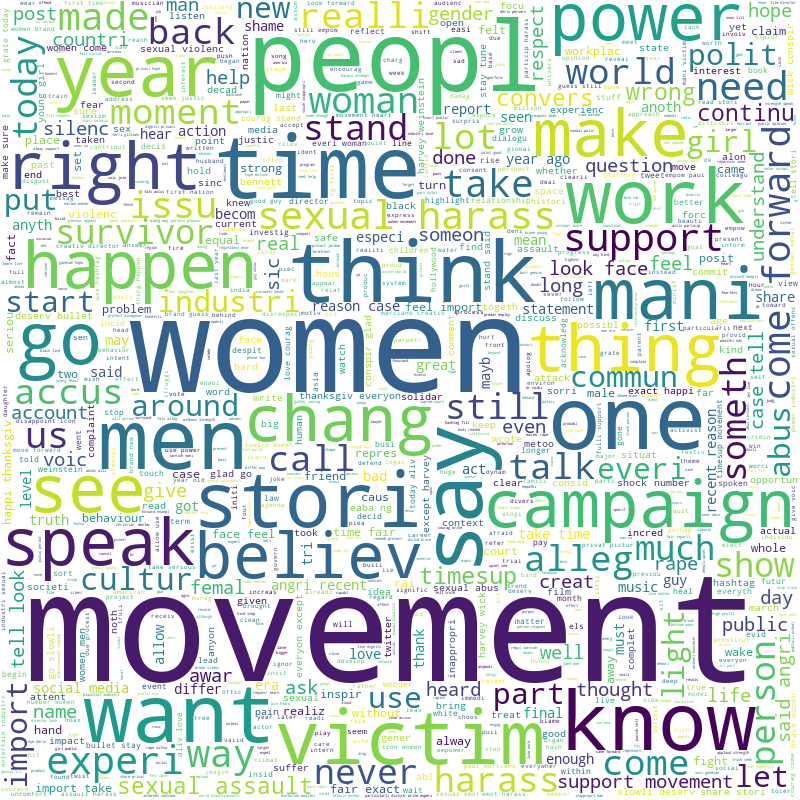

In [ ]:
#Create a word cloud from the extracted quotes
df = df.quotation.str.replace('metoo', ' ')
#Process texts in quotes
cleaned_text = df.apply(process_text)
#Join the different processed titles together.
long_string = ','.join([text for text_list in cleaned_text.values for text in text_list])
#Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
#Generate a word cloud
wordcloud.generate(long_string)
#Visualize the word cloud
wordcloud.to_image()

In [ ]:
#Filter the top words from word cloud using an arbitrarily threshold then sort them
filtered_words = dict()
#Iterate over all the items in dictionary
for (key, value) in wordcloud.words_.items():
    #Check if item satisfies the given condition then add to new dict
    #Set an arbitrarily value to shorten the list
    if value >= 0.15:
        filtered_words[key] = value
sorted_words = dict(sorted(filtered_words.items(), key=lambda kv: kv[1], reverse=True))

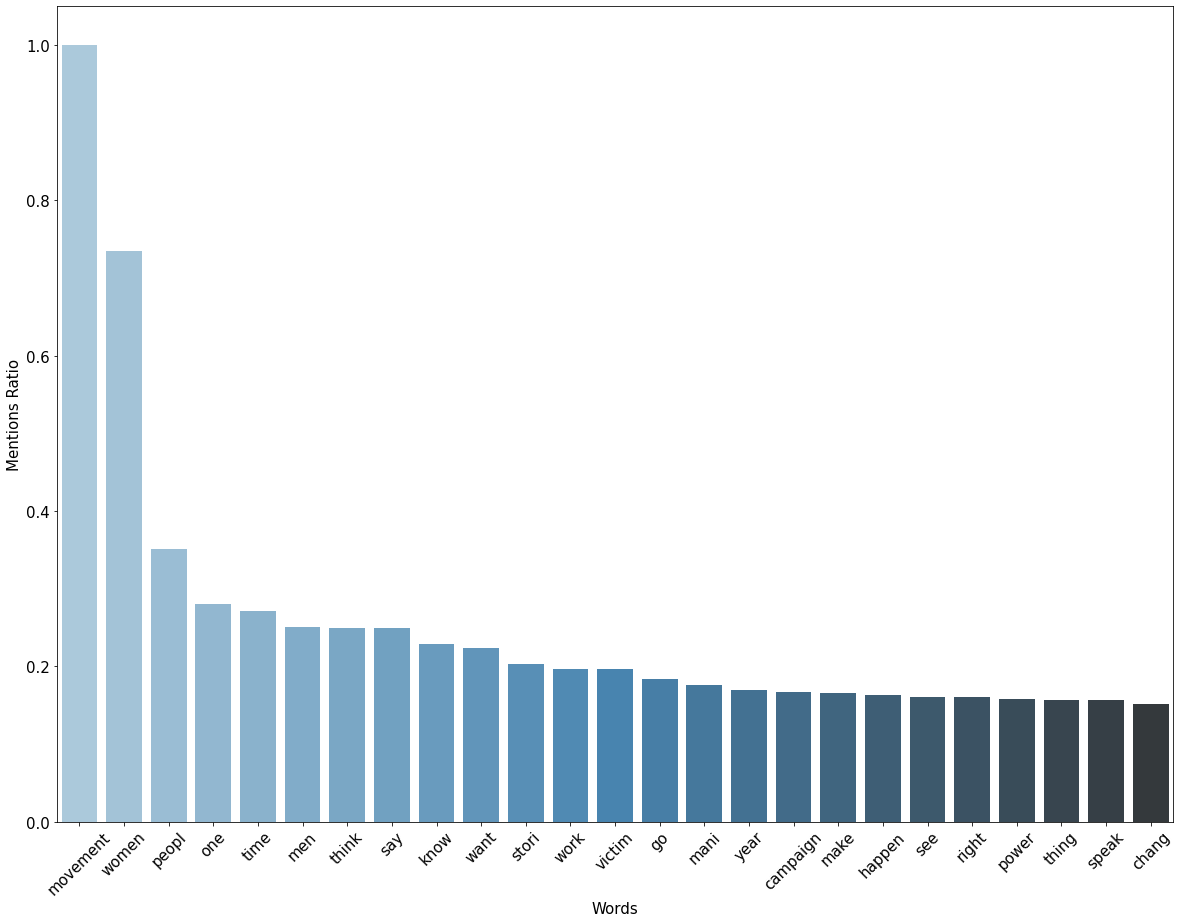

In [ ]:
#Visualize the mentions of the words generated from word cloud
words = pd.DataFrame({'words': list(sorted_words.keys()), 'mentions ratio': list(sorted_words.values())})
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,15))
ax = sns.barplot(x="words", y="mentions ratio", data=words, capsize=.5, ax=axis, palette="Blues_d")
ax.set_xlabel('Words', fontsize=15)
ax.set_ylabel('Mentions Ratio', fontsize=15)
ax.set_xticklabels(words['words'], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)

In [ ]:
#The final keywords compiled
keywords = ['movement', 'women', 'victim', 'campaign', 'sex', 'harass', 'assualt',
           'rape', 'misconduct', 'metoo', 'timesup', 'abuse', 'workplace', 'right', 'femin']
#Save the results from keywords extraction in this path
keywords_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/keywords-extracted-data.csv.bz2'

In [ ]:
#Iterate through all datasets and extract the quotes containing any of the keywords selected
for dataset in quote_datasets:
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', os.path.basename(dataset))
    for chunk in df_reader:
        chunk = process_chunk(chunk, manual_extraction, keywords, keywords_quotes_path)

In [ ]:
#Load the manually extracted data based on keywords
df = pd.read_csv(keywords_quotes_path, compression='bz2')
df = df.drop(df[df['quotation'] == 'quotation'].index)
df = df.drop(columns='Unnamed: 0')
print(f'The number of quotes that contain some of the selected keywords: {len(df)}')
df.head(10)

The number of quotes that contain some of the selected keywords: 6625708


,quoteID,quotation,speaker,qids,date,probas,urls
0,2015-08-31-000271,... a great day for veterans here in Littleton...,Jeanne Shaheen,['Q270316'],2015-08-31 02:10:00,"[['Jeanne Shaheen', '0.742'], ['None', '0.2359...",['http://www.unionleader.com/article/20150831/...
1,2015-10-29-035215,how the greatest movement came into being and ...,None,[],2015-10-29 21:25:14,"[['None', '0.5458'], ['Paul Hawken', '0.4542']]",['https://medium.com/enspiral-tales/bioneers-d...
2,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,['Q359442'],2015-10-25 14:12:35,"[['Bernie Sanders', '0.5395'], ['None', '0.312...",['http://examiner.com/article/bernie-sanders-s...
3,2015-10-17-000460,[ This is ] defamation. I'm hitting back. [ Me...,Meghan King Edmonds,['Q20684375'],2015-10-17 13:35:01,"[['Meghan King Edmonds', '0.7414'], ['None', '...",['http://www.inquisitr.com/2500312/vicki-gunva...
4,2015-09-04-030275,I ain't going nowhere. I'm going to be right h...,Letroy Guion,['Q13219370'],2015-09-04 12:36:42,"[['Letroy Guion', '0.7119'], ['None', '0.2804'...",['http://www.channel3000.com/sports/packers/Pa...
5,2015-12-01-033189,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,['Q76658'],2015-12-01 08:47:00,"[['Frank-Walter Steinmeier', '0.6923'], ['Mr H...",['http://express.co.uk/news/politics/623296/EU...
6,2015-02-03-000382,A careful analysis of the career histories of ...,Lisa Mainiero,['Q53121229'],2015-02-03 17:22:00,"[['Lisa Mainiero', '0.9511'], ['None', '0.0489']]",['http://www.forbes.com/sites/bonniemarcus/201...
7,2015-01-27-023512,I am honored and proud to raise awareness for ...,Joe Haden,['Q733737'],2015-01-27 13:25:00,"[['Joe Haden', '0.5859'], ['None', '0.3302'], ...",['http://www.istockanalyst.com/article/viewart...
8,2015-09-10-001454,"A couple bumps and bruises, but all right.",James Blake,"['Q350362', 'Q53333']",2015-09-10 06:31:35,"[['James Blake', '0.7538'], ['None', '0.2422']...",['http://rss.cnn.com/c/35494/f/676993/s/49bd29...
9,2015-09-23-032351,I am proud that once again I got to fly the So...,President Barack Obama,['Q76'],2015-09-23 06:04:06,"[['President Barack Obama', '0.6547'], ['None'...",['http://www.bdlive.co.za/business/management/...


In [ ]:
#Extract the Year-Month from the date column to plot a timeline of the selected quotes
df['y-m'] = df['date'].apply(lambda x: x[:7])
quotes_timeline = df[['y-m', 'quotation']].groupby(['y-m'], as_index=False)['quotation'].count()
quotes_timeline.head()

,y-m,quotation
0,2015-01,87584
1,2015-02,88268
2,2015-03,102218
3,2015-04,83233
4,2015-05,62275


In [ ]:
df['year'] = df['date'].apply(lambda x: x[:4])
quotes_timeline = df[['year', 'quotation']].groupby(['year'], as_index=False)['quotation'].count()
quotes_timeline.head()

,year,quotation
0,2015,1129612
1,2016,775557
2,2017,1507517
3,2018,1618392
4,2019,1290204


Text(0, 0.5, '# of Quotes')

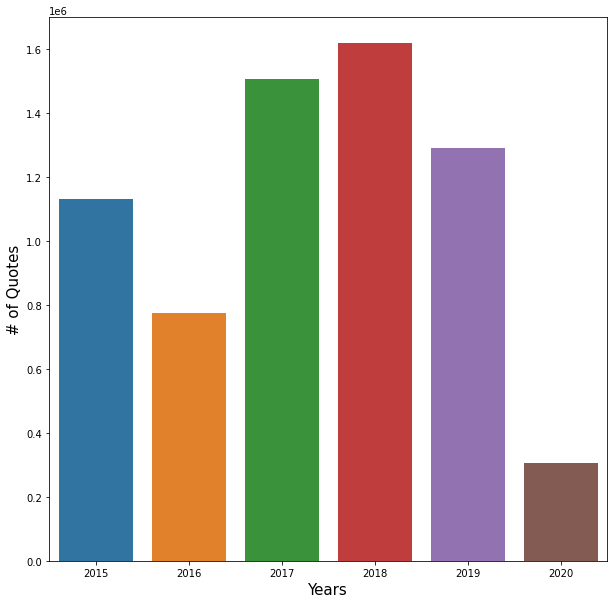

In [ ]:
#Visualize number of quotes per year
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = sns.barplot(x="year", data=quotes_timeline, capsize=.5, ax=axis)
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('# of Quotes', fontsize=15)

Text(0, 0.5, '# of Quotes')

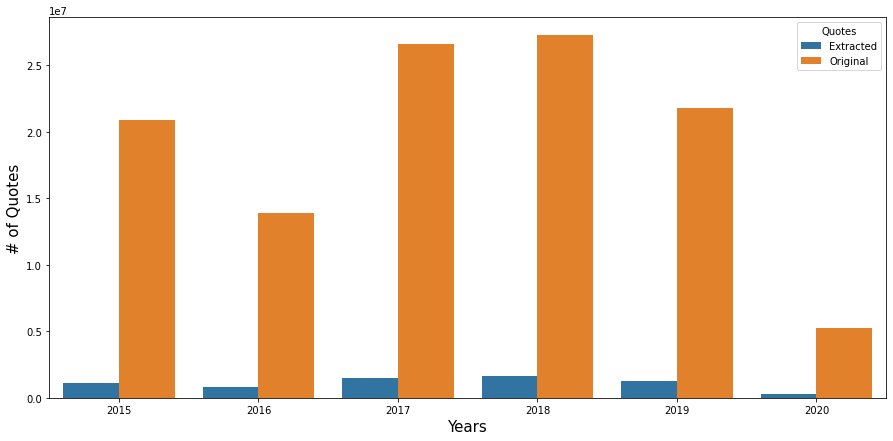

In [ ]:
#Compare the barplots of unfiltered vs filtered quotes
merged_df = pd.merge(quotes_timeline, df_quotes, on="year")
merged_df.rename(columns={'quotation': 'Extracted', 'num_quotes': 'Original'}, inplace=True)
test_data_melted = pd.melt(merged_df, id_vars='year',\
                           var_name="Quotes", value_name="value_numbers")
#Visualize number of quotes per year
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax = sns.barplot(x="year", y="value_numbers", hue='Quotes', data=test_data_melted, capsize=.5, ax=axis)
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('# of Quotes', fontsize=15)

#### <span style="color:purple"><div style="text-align: justify"> The final results of the *Manual Extraction Step* is manifested in the timeline plotted below of the number of extracted quotes across time.</div></span>

Text(0, 0.5, '# of Quotations')

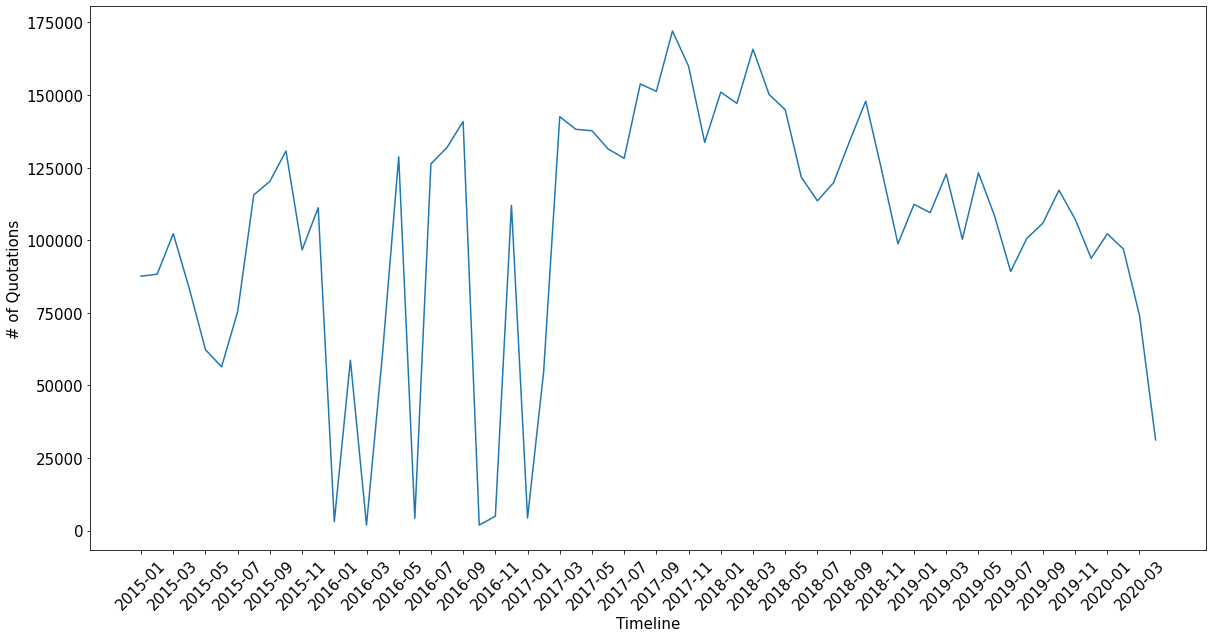

In [ ]:
#Visualizing the number of quotes throughout time
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(x='y-m', y='quotation', data=quotes_timeline, ax=axis)
ax.set_xticks(quotes_timeline['y-m'][::2])
ax.set_xticklabels(quotes_timeline['y-m'][::2], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Timeline', fontsize=15)
ax.set_ylabel('# of Quotations', fontsize=15)

#### <span style="color:purple"><div style="text-align: justify"> To account for the variation of quotes across the days of each month. We plotted the mean of quotes in each month in addition to showing the 95% confidence interval</div></span>

In [ ]:
#Extract the day from the date column
df['day'] = df['date'].apply(lambda x: x[8:10])
quotes_timeline = df[['y-m', 'day', 'quotation']].groupby(['y-m','day'], as_index=False)['quotation'].count()
quotes_timeline.head()

,y-m,day,quotation
0,2015-01,01,1312
1,2015-01,02,1924
2,2015-01,03,1319
3,2015-01,04,1382
4,2015-01,05,2501


Text(0, 0.5, '# of Quotations')

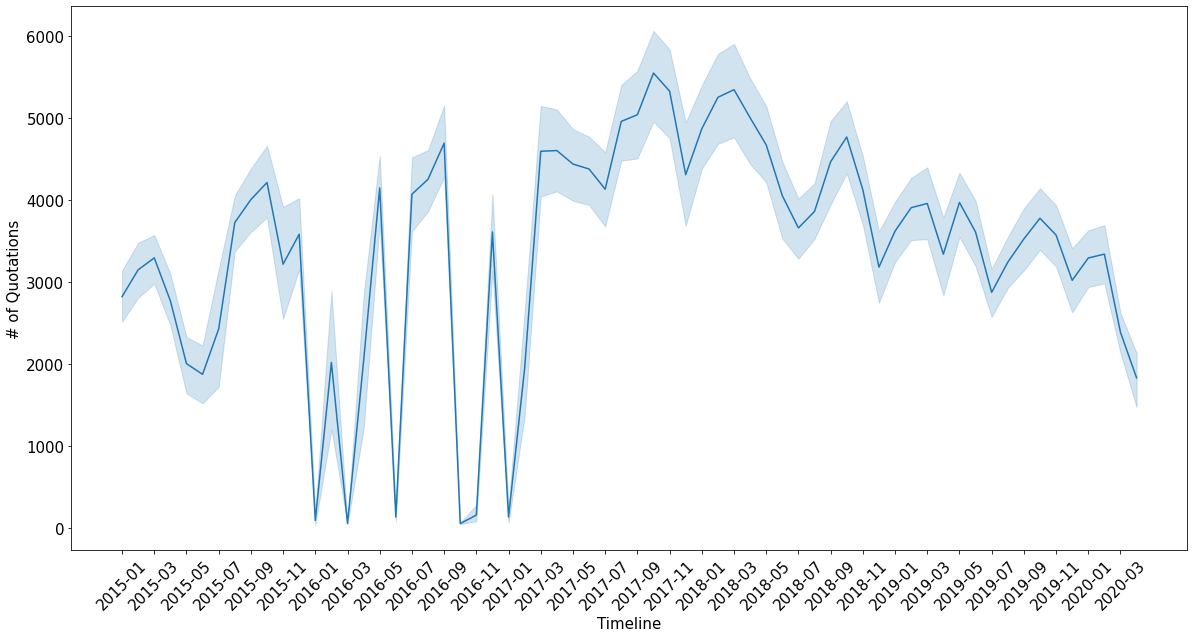

In [ ]:
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(x='y-m', y='quotation', data=quotes_timeline, ax=axis)
ax.set_xticks(np.sort(df['y-m'].unique())[::2])
ax.set_xticklabels(np.sort(df['y-m'].unique())[::2], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Timeline', fontsize=15)
ax.set_ylabel('# of Quotations', fontsize=15)

#### <span style="color:purple"><div style="text-align: justify">As mentioned in the ReadMe, the timeline plotted above will be used with the tweets timeline as a proxy for the impact caused by a specific event.</div></span>

---

### <span style="color:green">B- Parsing URLs Method</span>

#### <span style="color:purple"><div style="text-align: justify">This method would help filter quotes based on the article title which would be extracted from the urls. First, we will extract the hostnames of the urls. Then, pick the top 10 hostnames in terms of occurences, as an example, and extract their titles to hand-pick the relevent titles.</div></span>

#### <span style="color:red"><div style="text-align: justify">NOTE: In the end we didn't use this method as shown in the diagram above because it was not efficient and didn't yield consistent results since we had to hard-code the parsing method depending on the news website.</div></span>

In [ ]:
# After building a dataset which contains URLs, hostnames and the title for the top 10 most cited websites hosts ()
# Now we build a dictionnary where each entry contains a host name the position of the title in the URL for that hostname
positions = {}
positions["http://www.breitbart.com/"] = 5
positions["http://msn.com/"] = 4
positions["http://newsok.com/"] = 1
positions["http://express.co.uk/"] = 4
positions[" https://www.washingtonpost.com/"] = 2
positions["http://thehill.com/"] = 3
positions["http://mlb.mlb.com/"] = 4
positions["http://msn.com/"] = 4
positions["https://www.seattletimes.com/"] = 3
positions["https://www.thesun.co.uk/"] = 3
positions["http://www.huffingtonpost.com/"] = 4
positions["http://feeds.foxnews.com/"] = 5

In [ ]:
pattern = '|'.join(positions.keys())
df_reader = pd.read_csv("/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/urls_hostnames_titles_keywords-extracted-quotes.csv.bz2", compression='bz2')
df_reader = df_reader.drop(columns= ['Unnamed: 0','Unnamed: 0.1'])

In [ ]:
df_reader = df_reader.rename({'host name': 'Hostname', 'title3': 'Title'}, axis=1)  # new method

In [ ]:
df_reader.loc[df_reader["Hostname"].str.contains(pattern)].sample(50)

,urls,Hostname,Title
1160982,['http://www.huffingtonpost.com/carl-safina/pe...,http://www.huffingtonpost.com/,NaN
2775288,['http://thehill.com/blogs/blog-briefing-room/...,http://thehill.com/,353030-evangelicals-urge-trump-to-act-more-on-...
4941336,['http://mlb.mlb.com/news/article/sf/travis-be...,http://mlb.mlb.com/,travis-bergen-drew-ferguson-taken-by-giants
804758,['http://mlb.mlb.com/news/article/tex/rangers-...,http://mlb.mlb.com/,rangers-on-a-roll-with-win-over-astros
5352117,['https://www.seattletimes.com/sports/usman-ba...,https://www.seattletimes.com/,NaN
3150371,['http://newsok.com/quiet-zoom-electric-car-ra...,http://newsok.com/,quiet-zoom-electric-car-race-comes-to-brooklyn...
3539178,['http://msn.com/en-xl/northamerica/northameri...,http://msn.com/,17-ways-youre-actually-offending-people-when-a...
2346406,['http://newsok.com/german-state-vote-a-test-f...,http://newsok.com/,german-state-vote-a-test-for-merkels-party-res...
5270658,['https://www.seattletimes.com/nation-world/na...,https://www.seattletimes.com/,hawaii-woman-missing-for-2-weeks-rescued-from-...
544473,['http://express.co.uk/celebrity-news/615966/G...,http://express.co.uk/,NaN


---

### <span style="color:green">C- NLP-based Method</span>

#### <span style="color:purple"><div style="text-align: justify">The quotes extracted so far could some of them still not be related to *Sexual Harassment*. Hence, in this step, we will explore different NLP-based methods to properly perform *Topic Modeling* and only save the related quotes to our project</div></span>

#### <span style="color:purple"><div style="text-align: justify">Below are the methods explored, the reason why we used them and sample of the results. But first let's apply some basic NLP preprocessing to prepare the quotes, including:</div></span>

##### <span style="color:orange">
- Tokenization using *NLTK*.
- Removing *Stop Words*
- Removing *Punctuation Symbols*
- Stemming words to their roots
</span>

#### <span style="color:purple"><div style="text-align: justify">After applying preprocessing on the manually extracted quotes, save the new format *(List of words)* in a pickle file.</div></span>

In [ ]:
#Path for saved list of words
save_pickle_file = _DATASETS_PATHS+'/lists_of_words.pkl'

In [ ]:
#Read the extracted quotes as chunck of 0.5M to preprocess them
quotes_list = []
df_reader = pd.read_csv(keywords_quotes_path, compression='bz2', chunksize=500000)
print('Processing Data:', os.path.basename(dataset))
for chunk in df_reader:
  #Open pickle file in append mode
  with open(save_pickle_file, 'ab') as f:
    chunk = chunk.drop(chunk[chunk == 'quotation'].index)
    chunk = chunk.drop(columns='Unnamed: 0')
    #Preprocess text using NLTK library (function is in utils.py)
    pickle.dump(process_text(chunk), f)

Processing Data: keywords-extracted-quotes.csv.bz2


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 125941 rows
Index(['quotation'], dtype='object')


In [ ]:
#Load the saved pickle file
list_words = list(pd.read_pickle(save_pickle_file))

In [ ]:
#Sample
list_words[10]

['journey',
 'space',
 'captur',
 'one',
 'singl',
 'shot',
 'show',
 'subtl',
 'push',
 'pull',
 'masculin',
 'feminin']

#### <span style="color:magenta">1- LDA *(Latent Dirichlet Allocation)*</span>

##### <span style="color:orange"><div style="text-align: justify">We explored this method because LDA tries to map all the text data to the (unknown) topics in a way such that the words in each quote are mostly captured by those topics. The fundamental assumption here is that quotes with the same topic will use similar words. It's also assumed that every quote is composed of a mixture of topics, and every word has a probability of belonging to a certain topic.</div></span>

##### <span style="color:orange"><div style="text-align: justify">We applied two LDA layers (as showcased in the diagram above). The first layer gave different 4 topics and we related the quotes to the second one and got 800K quotes out of 6M. The second layer created another 4 topics and we picked the third and finally got 150K quotes at the end.</div></span>

In [ ]:
#Create a Gensim dictionary from the data using the bag of words model
dictionary = corpora.Dictionary(list_words)
corpus = [dictionary.doc2bow(word) for word in list_words]
#Train an LDA model using the corpus created (with )
model = models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [ ]:
#Save trained model to disk.
temp_file = datapath("model")
model.save(temp_file)

In [ ]:
import pickle
#Print the 5 topics detected with their common four words (First LDA)
model = pickle.load(open(_DATASETS_PATHS+'/lda_model.pkl', 'rb'))
topics = model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.060*"women" + 0.033*"campaign" + 0.012*"peopl" + 0.011*"men"')
(1, '0.021*"victim" + 0.018*"abus" + 0.014*"sexual" + 0.009*"sex"')
(2, '0.069*"right" + 0.024*"go" + 0.020*"get" + 0.018*"think"')
(3, '0.047*"right" + 0.010*"peopl" + 0.009*"need" + 0.008*"govern"')
(4, '0.013*"new" + 0.008*"year" + 0.007*"bright" + 0.006*"world"')


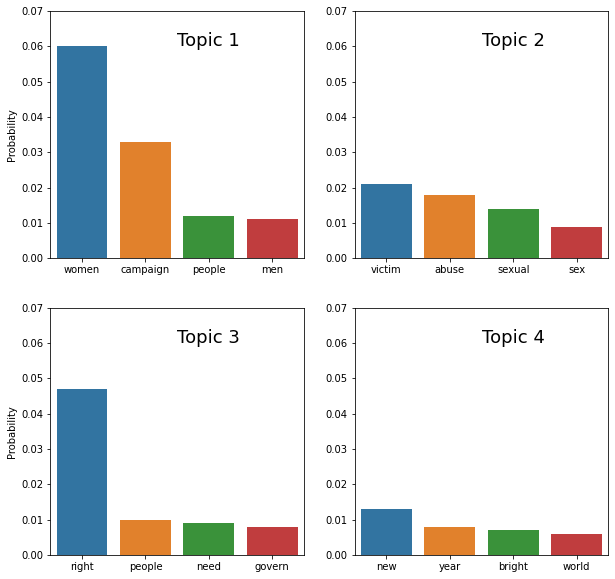

In [ ]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
topic0 = [0.060, 0.033, 0.012, 0.011]
words0 = ['women', 'campaign', 'people', 'men']
topic1 = [0.021, 0.018, 0.014, 0.009]
words1 = ['victim', 'abuse', 'sexual', 'sex']
topic2 = [0.047, 0.010, 0.009, 0.008]
words2 = ['right', 'people', 'need', 'govern']
topic3 = [0.013, 0.008, 0.007, 0.006]
words3 = ["new", "year" ,"bright","world"]


g = sns.barplot(x=words0, y=topic0, ax=ax[0,0])
g.text(2,0.06,'Topic 1', color='black', ha="center", fontsize=18)
g=sns.barplot(x=words1, y=topic1, ax=ax[0,1])
g.text(2,0.06,'Topic 2', color='black', ha="center", fontsize=18)
g=sns.barplot(x=words2, y=topic2, ax=ax[1,0])
g.text(2,0.06,'Topic 3', color='black', ha="center", fontsize=18)
g=sns.barplot(x=words3, y=topic3, ax=ax[1,1])
g.text(2,0.06,'Topic 4', color='black', ha="center", fontsize=18)
ax[0,0].set_ylim([0, 0.07])
ax[0,0].set_ylabel('Probability')
ax[0,1].set_ylim([0, 0.07])
ax[1,0].set_ylim([0, 0.07])
ax[1,0].set_ylabel('Probability')
ax[1,1].set_ylim([0, 0.07])
_.savefig('ldatopics.png')

In [ ]:
import pickle
#Load the second trained LDA model
model = pickle.load(open(_DATASETS_PATHS+'/lda_second_model.pkl', 'rb'))
topics = model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.019*"right" + 0.011*"work" + 0.011*"new" + 0.009*"campaign"')
(1, '0.065*"right" + 0.023*"go" + 0.020*"get" + 0.018*"think"')
(2, '0.031*"right" + 0.013*"campaign" + 0.012*"victim" + 0.010*"peopl"')
(3, '0.050*"women" + 0.011*"peopl" + 0.011*"sexual" + 0.010*"men"')


#### <span style="color:magenta">2- Word2Vec Model</span>

##### <span style="color:orange"><div style="text-align: justify">A different way to investigate topics is to extract word embeddings and train a model on these embeddings to detect similarities.</div></span>

##### <span style="color:red"><div style="text-align: justify">NOTE: we haven't used this method at the end and replaced it with BERT.</div></span>

In [ ]:
#Train word2vec on list of words
model = models.Word2Vec(list_words, min_count=1,size= 100,workers=3, window =3, sg = 1)

In [ ]:
#Print the top 5 similar words to harass (cosine similarity)
model.most_similar('harass', topn=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('intimid', 0.8215645551681519),
 ('retali', 0.7891688942909241),
 ('bulli', 0.7701835632324219),
 ('victimis', 0.7539269924163818),
 ('stalk', 0.7376947402954102)]

#### <span style="color:magenta">3- GloVe Model</span>

##### <span style="color:orange"><div style="text-align: justify">Here, we use another word embedding method and we used a pre-trained model*‘glove-wiki-gigaword-300’* which is a model learned using GloVe on the wikipedia and gigaword corpuses with an embedding size of 300.</div></span>

##### <span style="color:red"><div style="text-align: justify">NOTE: This method was compared with BERT and we found that BERT gives more consistent results at the end.</div></span>

In [ ]:
#Save the list of words in a dataframe to process them
embeddedDF = pd.DataFrame({'scentences': list_words})
dataDF = embeddedDF.copy()
embeddedDF.head()

,scentences
0,"[great, day, veteran, littleton, across, north..."
1,"[greatest, movement, came, one, saw, come]"
2,"[ever, gold, standard, trade, agreement, sande..."
3,"[defam, hit, back, meghan, chanc, make, right,..."
4,"[go, nowher, go, right, green, bay, green, bay..."


In [ ]:
#Load pretrained model
word_vectors = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
#Extract word embeddings
embeddedDF['scentences'] = embeddedDF['scentences'].apply(lambda x: embedSentence(x, word_vectors))
#Will be useful later for combining dataframes
keepIndices = embeddedDF.index
#Average the embeddings of words in one scentence
embeddedDF['scentences'] = embeddedDF['scentences'].apply(averageEmbedding)

In [ ]:
#Print the embeddings generated for each quote
embeddedDF.index = list(range(0, len(embeddedDF)))
embeddedDF.head()

,scentences
0,"[-0.026508026, 0.03706931, 0.006902222, -0.178..."
1,"[0.057423335, 0.053511336, -0.12297001, -0.084..."
2,"[-0.12058276, -0.00594178, 0.024895065, -0.061..."
3,"[0.16207139, -0.109700255, -0.23056835, -0.235..."
4,"[0.042109244, -0.16742308, -0.053067572, -0.14..."


In [ ]:
#Put every feature in one column to perform clustering later
FeatureColumns = []
for i in range(0, 300):
    FeatureColumns.append('e'+str(i))
FeatureDF = pd.DataFrame(columns = FeatureColumns)
FeatureDF

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20,e21,e22,e23,e24,e25,e26,e27,e28,e29,e30,e31,e32,e33,e34,e35,e36,e37,e38,e39,...,e260,e261,e262,e263,e264,e265,e266,e267,e268,e269,e270,e271,e272,e273,e274,e275,e276,e277,e278,e279,e280,e281,e282,e283,e284,e285,e286,e287,e288,e289,e290,e291,e292,e293,e294,e295,e296,e297,e298,e299


In [ ]:
#Fill the dataframe of the 300 dim. embeddings for each quote (Do it only for 500 quotes as an example)
for i in range(0, 10000):
    FeatureDF = featurize(list(embeddedDF['scentences'][i]), FeatureDF, FeatureColumns)

In [ ]:
FeatureDF

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20,e21,e22,e23,e24,e25,e26,e27,e28,e29,e30,e31,e32,e33,e34,e35,e36,e37,e38,e39,...,e260,e261,e262,e263,e264,e265,e266,e267,e268,e269,e270,e271,e272,e273,e274,e275,e276,e277,e278,e279,e280,e281,e282,e283,e284,e285,e286,e287,e288,e289,e290,e291,e292,e293,e294,e295,e296,e297,e298,e299
0,-0.026508,0.037069,0.006902,-0.178344,0.050720,0.176376,0.007358,0.110989,-0.030168,-1.089261,0.069331,-0.079475,-0.103143,-0.087345,0.000366,0.002424,0.010747,-0.081182,-0.118117,-0.090676,0.019262,0.030227,0.233157,-0.001839,-0.113459,-0.024372,0.061364,0.030928,-0.010622,0.102249,0.116715,0.053811,-0.031828,-0.093769,-0.476299,0.020398,-0.076365,-0.030323,0.033583,-0.090548,...,0.011528,-0.324348,0.106132,-0.021212,-0.062750,0.012943,-0.087967,-0.098352,0.039606,0.141361,-0.051144,0.040277,0.153550,0.151160,0.037832,-0.043198,-1.562571,0.017811,0.261853,0.009014,-0.103165,-0.057659,0.147159,0.069340,-0.020078,0.145310,-0.010974,0.100347,-0.008387,-0.044727,-0.024880,-0.130360,0.029168,-0.092657,-0.050515,0.141899,0.156109,-0.064615,-0.087820,0.007144
1,0.057423,0.053511,-0.122970,-0.084723,-0.071899,-0.050390,-0.207617,0.021884,-0.100625,-1.252237,0.025337,0.036132,-0.107488,0.062042,0.295324,-0.012174,-0.052582,0.010444,-0.260360,0.077610,0.026544,0.249801,0.147663,0.083652,-0.006733,-0.048520,-0.010983,-0.071083,0.061340,-0.062689,0.012804,0.147395,-0.421612,0.019133,-1.011595,-0.109292,0.031445,0.197551,-0.041128,0.102054,...,0.080555,-0.160563,0.257300,-0.019064,-0.294272,-0.016883,-0.428845,-0.079356,0.041838,0.231710,0.036581,-0.006977,0.153281,-0.002951,0.055170,-0.074733,-1.942217,-0.130380,0.375715,0.133934,-0.212890,-0.003289,0.026812,0.102263,0.122189,0.030870,-0.047775,-0.090095,0.029569,0.069620,-0.171218,-0.136792,0.008716,-0.020661,0.159377,0.320938,0.008793,-0.101725,-0.047420,-0.108346
2,-0.120583,-0.005942,0.024895,-0.061419,-0.000128,0.029264,-0.061267,-0.035724,0.049884,-1.276448,0.040843,-0.030851,-0.108325,0.045811,0.040826,0.075104,-0.084356,-0.000592,0.015809,-0.099551,0.000190,-0.039672,0.266465,0.004056,-0.228149,-0.012936,0.025665,-0.139431,0.015768,0.178645,0.059680,0.099367,-0.057100,0.102550,-0.817293,0.007638,-0.089671,-0.057756,0.042440,-0.021510,...,-0.107159,-0.080562,0.086834,0.072408,-0.048265,0.154698,-0.004168,-0.059697,0.051268,0.035577,-0.010520,-0.017824,0.103536,0.111679,0.143799,-0.031270,-1.650070,-0.119217,0.334734,0.070160,-0.003548,-0.034720,0.042184,-0.130482,-0.039743,0.169180,-0.023832,0.003896,-0.062111,0.023564,-0.074584,-0.058256,0.013461,0.134476,0.016178,0.364463,0.010399,-0.130535,-0.150044,0.066149
3,0.162071,-0.109700,-0.230568,-0.235123,-0.119905,0.076039,-0.136997,-0.160858,-0.050969,-0.650223,-0.024653,-0.012600,-0.031959,-0.204068,-0.152303,0.098191,-0.282249,-0.023054,0.070692,0.095224,0.065234,0.023182,0.087587,-0.187440,-0.183018,0.088329,0.046645,-0.116592,-0.106862,0.111273,-0.085783,0.084935,-0.206932,0.086000,-0.719705,0.070701,-0.185177,-0.123967,-0.004159,0.086180,...,-0.232062,0.027024,0.128317,-0.032577,-0.023962,-0.151807,-0.101980,-0.048808,-0.088250,0.166931,0.044570,-0.160128,-0.079025,0.164128,0.003268,-0.163123,-0.921164,-0.110675,-0.050396,-0.211479,-0.097012,0.167657,-0.092780,0.075664,-0.242300,0.288187,0.114453,-0.026453,0.026446,0.042462,0.046458,-0.133462,0.239502,0.000098,-0.129399,-0.100935,0.193149,-0.065911,0.064490,0.085454
4,0.042109,-0.167423,-0.053068,-0.144757,0.058345,-0.010240,-0.041086,0.059599,-0.028824,-0.707056,0.055102,-0.149371,-0.009881,-0.017733,0.158022,0.235062,-0.213982,-0.090593,0.106130,0.287466,-0.085954,-0.064298,0.042409,-0.168166,-0.131549,-0.145735,0.018289,0.139696,-0.177467,0.058624,0.056461,0.103976,-0.121762,0.050272,-0.620897,0.214386,-0.137524,-0.192407,-0.088743,-0.286339,...,-0.104864,-0.156560,0.159751,-0.046883,-0.120081,-0.048749,0.029167,-0.013193,-0.025623,-0.093208,-0.132283,-0.286383,0.020548,0.059173,-0.029095,0.016851,-1.335361,0.054880,-0.02835

In [ ]:
#Apply tSNE to reduce the dimentionality and project the data on 2D plane
tempDF = dataDF.loc[keepIndices, :].copy()
tempDF.index = range(0, len(tempDF))
scaler = StandardScaler()
currentScaledDF = scaler.fit_transform(FeatureDF.loc[:, :'e299'])
tsne = TSNE(n_components=2).fit_transform(currentScaledDF)
tsneDF = pd.DataFrame(tsne, columns=['T1', 'T2'])
tsneDF

,T1,T2
0,6.764998,-10.616425
1,30.308577,-16.472586
2,31.573599,-6.972002
3,14.569444,24.022837
4,17.838402,16.438162
...,...,...
9995,11.223802,-0.093008
9996,35.357815,2.925419
9997,28.234873,12.471493
9998,8.151303,-12.607251


In [ ]:
#Print the tSNE values
tsneDF = pd.concat([tsneDF, dataDF.loc[:10000, 'scentences':]], axis =1)
tsneDF['scentences'] = tsneDF['scentences'].apply(TreebankWordDetokenizer().detokenize)
tsneDF.head()

,T1,T2,scentences
0,8.654921,1.632568,great day veteran littleton across north count...
1,10.102067,-1.294602,greatest movement came one saw come
2,10.312236,-2.311534,ever gold standard trade agreement sander said...
3,-2.412457,-2.369984,defam hit back meghan chanc make right see
4,5.635272,-0.358719,go nowher go right green bay green bay home bo...


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


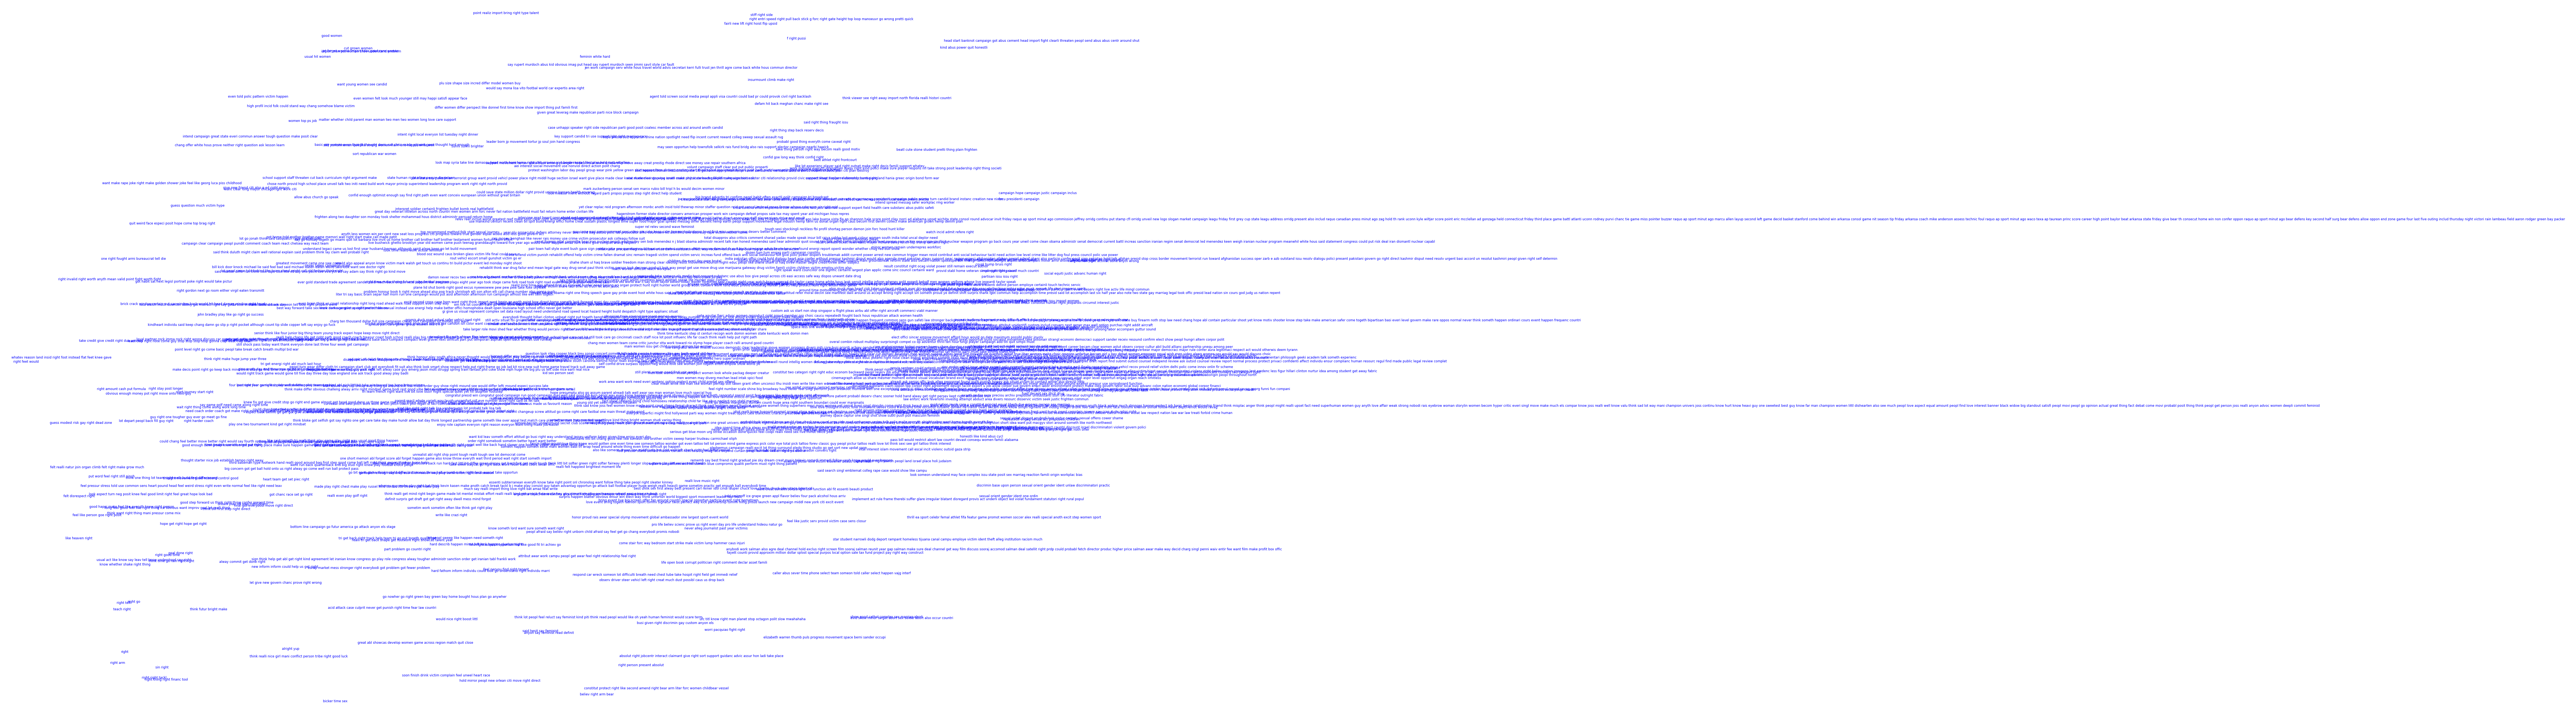

In [ ]:
#Scale between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(tsneDF.iloc[:, [0,1]])
#Plot the tSNE values woth their corresponding scentences
tsneDF.iloc[:, [0,1]] = data
plotWords(tsneDF)

Text(0.5, 1.0, 'tSNE Visualization')

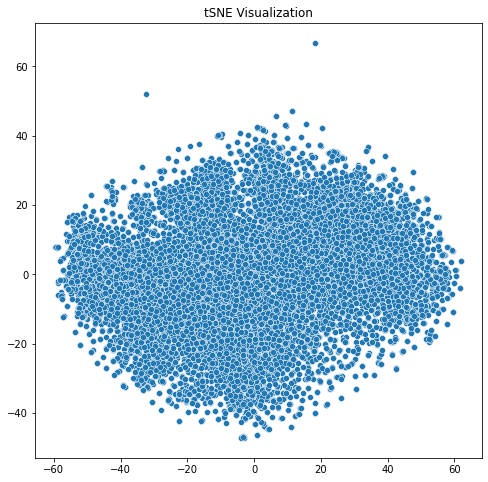

In [ ]:
#Plot a clearer figure without quotes mentioned
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], ax=ax)
ax.set_title('tSNE Visualization')

#### <span style="color:purple"><div style="text-align: justify">The plot above shows that the sample used (10,000 quotes) are clustered in this manner when they are reduced to 2D.</div></span>

#### <span style="color:magenta">4- BERT Model</span>

##### <span style="color:orange"><div style="text-align: justify">We were motivated to test BERT Model because it could help us extract conceptualized quote embeddings and then use it to filter quotes.</div></span>

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 37.5 MB/s 
     |████████████████████████████████| 61 kB 501 kB/s 
     |████████████████████████████████| 895 kB 45.3 MB/s 
     |████████████████████████████████| 3.3 MB 19.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Checking for GPU availabitlity and seeing if it is being used
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Just to try we'll try to load the entire dataset in one run, it's not a problem !! 
metoo_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/first_layer_lda_filteration.csv.bz2'
df_reader = pd.read_csv(metoo_quotes_path, compression='bz2')

In [ ]:
# Importing the relevant modules
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch

import nltk
# Loading the pre-trained BERT model
###################################
# Embeddings will be derived from
# the outputs of this model
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True,).to(device)
# Setting up the tokenizer
###################################
# This is the same tokenizer that
# was used in the model to generate
# embeddings to ensure consistency
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for BERT
    
    Takes a string argument and performs
    pre-processing like adding special tokens,
    tokenization, tokens to ids, and tokens to
    segment ids. All tokens are mapped to seg-
    ment id = 1.
    
    Args:
        text (str): Text to be converted
        tokenizer (obj): Tokenizer object
            to convert text into BERT-re-
            adable tokens and ids
        
    Returns:
        list: List of BERT-readable tokens
        obj: Torch tensor with token ids
        obj: Torch tensor segment ids
    
    
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_tensors = torch.tensor([segments_ids]).to(device)

    return tokenized_text, tokens_tensor, segments_tensors
    
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

In [ ]:
#For the BERT analysis to work we need to feed it each quote in a list
texts = list(df_reader.quotation)
del(df_reader)
FeatureColumns = []
sentence_embeddings = np.zeros([len(texts),768])

In [ ]:
np.shape(sentence_embeddings)

(893515, 768)

In [ ]:
# we will also save the quote IDs for merging later (This can probably be done in a cleaner way though)
# Getting the average embeddings for each quote
for i,text in enumerate(texts):
  try:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)    
    sentence_embeddings[i,:] = (np.mean(np.asarray(list_token_embeddings), axis = 0))
    if i % 10000 == 0:
      print("This quote is done", i)
      np.savez_compressed('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/sentence_BERT_embeddings_800K', a=sentence_embeddings)
    elif i == len(texts):
      print("This is the final quote", i)
      np.savez_compressed('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/sentence_BERT_embeddings_800K_final', a=sentence_embeddings)

  except: 
    print("Skipped quote", i)
    sentence_embeddings[i,:] = np.zeros(768)

In [ ]:
# we will also save the quote IDs for merging later (This can probably be done in a cleaner way though)
# Getting the average embeddings for each quote
# google collab crashed after reaching quote nr 320 000

for i in range(len(texts)):
  j = i + 320000
  try:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(texts[j], tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)    
    sentence_embeddings[j,:] = (np.mean(np.asarray(list_token_embeddings), axis = 0))
    if j % 10000 == 0:
      print("This quote is done", j)
      np.savez_compressed('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/sentence_BERT_embeddings_second_part', b=sentence_embeddings)

    if j == len(df_reader.index):
      print("This is the final quote", j)
      np.savez_compressed('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/sentence_BERT_embeddings_second_part', b=sentence_embeddings)
  except: 
    print("Skipped quote", j)
    sentence_embeddings[j,:] = np.zeros(768)

In [15]:
# Now we just have to combine the previously made arrays
with np.load("/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/sentence_BERT_embeddings.npz") as data:
    quotes = data['a']
np.shape(quotes)

(387946, 768)

In [ ]:
#Save the list of words in a dataframe to process them
#Read the extracted quotes as chunck of to preprocess them
# It would probably be better to set the size of "embeddings to be the len of the number of quotes "
metoo_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/second_layer_lda_filteration.csv.bz2'
quotes_list = []
embeddings = []
# We'll be reading 100 000 quotes at a time
df_reader = pd.read_csv(metoo_quotes_path, compression='bz2', chunksize=100000)
IDs = []
i = 0
for chunk in df_reader:
  #For the BERT analysis to work we need to feed it each quote in a list
  texts = list(chunk.quotation)
  # we will also save the quote IDs for merging later (This can probably be done in a cleaner way though)
  IDs.append(list(chunk.quoteID))
  # Getting the average embeddings for each quote
  for text in texts:
    i+=1
    try:
      tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
      list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)    
    #print(i)
    # Taking the average embedding for each quote
      embeddings.append(np.mean(np.asarray(list_token_embeddings), axis = 0))

    except: 
      print("Skipped quote", i)
      embeddings.append(np.zeros(768))

##### <span style="color:orange"><div style="text-align: justify">After generating the embeddings of the filtered quotes (from the first LDA layer) using BERT, we applied PCA to reduce dimentionality and visualize the embeddings of the filtered quotes.</div></span>

In [ ]:
# Doing the same analysis as with tsne but with PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
with np.load("/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/sentence_BERT_embeddings_800K_P1-2-3-4.npz") as data:
  x = data['a']

In [ ]:
# Standardizing the features as is common practice before PCA
x = x[:600000, :] #trying with 600 000 rows as 870 000 causes crashing
x = StandardScaler().fit_transform(x)


In [ ]:
from sklearn.decomposition import PCA
# We only keep the first two principal components to be able to show it in 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
del(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2'])


In [ ]:
# Loading the topics assigned by the second LDA
import pickle
with open('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/topics_of800K.pkl', 'rb') as f:
    data = pickle.load(f)
data = map(str, data) 

topics = []
for topic in data:
    if topic == '0': 
      new_string = "US-politics"
    elif topic == '1': 
      new_string = "Sports"
    elif topic == '2': 
      new_string ="Global-politics"
    elif topic == '3':
      new_string = "Sexual harassment"
    topics.append(new_string)
del data

In [ ]:
# Loading the quotes for the hover plot

metoo_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/first_layer_lda_filteration.csv.bz2'
quotes = pd.read_csv(metoo_quotes_path, compression='bz2')

In [ ]:
quotes.head()

,Unnamed: 0,quoteID,quotation,speaker,qids,date,probas,urls
0,20,2015-04-07-001560,"a tough, sexy and shockingly reckless FBI prof...",Eliza Dushku,['Q210200'],2015-04-07 06:59:41,"[['Eliza Dushku', '0.673'], ['None', '0.2795']...",['http://www.tvovermind.com/banshee/eliza-dush...
1,27,2015-12-17-004153,agents are told that they should not be screen...,Martha MacCallum,['Q6774476'],2015-12-17 23:45:20,"[['Martha MacCallum', '0.77'], ['None', '0.206...",['http://mediamatters.org/research/2015/12/17/...
2,29,2015-10-18-002421,"All have sinned, am I right about it?",None,[],2015-10-18 22:56:39,"[['None', '0.8051'], ['Dylann Roof', '0.1949']]",['http://www.thestate.com/news/state/charlesto...
3,35,2015-03-04-003313,allow these abuses in the Church to go on and ...,None,[],2015-03-04 22:21:05,"[['None', '0.4972'], ['Tom Cruise', '0.1883'],...",['http://feeds.cbsnews.com/~r/CBSNewsEntertain...
4,36,2015-02-05-003407,Allowing law enforcement to take property from...,Scott Bullock,['Q7436070'],2015-02-05 22:20:22,"[['Scott Bullock', '0.9607'], ['None', '0.0393']]",['http://freebeacon.com/issues/report-irs-seiz...


In [ ]:
# Adding these quotes as columns to the DF
principalDf["quotes"] = quotes["quotation"].iloc[:600000]
# We wrap the quotes to prevent te
principalDf["quotes"] = principalDf["quotes"].str.wrap(70)
principalDf["quotes"]= principalDf["quotes"].apply(lambda x: x.replace('\n', '<br>'))
principalDf["speaker"] = quotes["speaker"].iloc[:600000]
principalDf["topic"] = topics[:600000]

In [ ]:
principalDf.head()

,PC 1,PC 2,quotes,speaker,topic
0,3.205232,3.810538,"a tough, sexy and shockingly reckless FBI prof...",Eliza Dushku,Global-politics
1,6.348039,4.287417,agents are told that they should not be screen...,Martha MacCallum,Global-politics
2,1.127015,2.062852,"All have sinned, am I right about it?",None,Sexual harassment
3,3.998340,0.265028,allow these abuses in the Church to go on and ...,None,Sexual harassment
4,10.836280,8.935939,Allowing law enforcement to take property from...,Scott Bullock,Global-politics


In [ ]:
# Making the plot

import plotly.express as px

fig = px.scatter(principalDf.sample(n=1000), x="PC 1", y="PC 2", hover_data=["quotes", "speaker"], width = 800, height = 800)

fig.show()

fig.write_html("PCA_600K_good_size_no_colour.html")
from google.colab import files
files.download('PCA_600K_good_size_no_colour.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Making the plot

import plotly.express as px

fig = px.scatter(principalDf.sample(n=1000), x="PC 1", y="PC 2", hover_data=["quotes", "speaker"], width = 800, height = 800, color = "topic")

fig.show()

fig.write_html("PCA_600K.html")
from google.colab import files
files.download('PCA_600K.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## <span style="color:Blue">3) Dataset Augmentation</span>

### <span style="color:Red"><div style="text-align: justify">Here, we enrich our dataset with external ones, so we explore each external dataset and apply preliminary analysis on them.</div></span>

### <span style="color:green">A- Twitter Dataset</span>

#### <span style="color:Purple"><div style="text-align: justify">The tweets dataset is acquired from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/2SRSKJ) which contains 32,071,469 *metoo* tweets ranging from October 15, 2017 to March 31, 2020. The dataset only contains tweet IDs, thus, we applied for access to Twitter API in order to fetch tweets and their metadata from IDs. The dataset is distributed in 33 txt files *(each containing 1M tweet IDs)*.</div></span>

In [ ]:
#Tweet IDs paths
tweet_ids_paths = sorted(glob.glob(_DATASETS_PATHS+'/me_too_tweets/*.txt'))
print(f' There are {len(tweet_ids_paths)} files of tweet IDs')

 There are 33 files of tweet IDs


In [ ]:
#Twitter Developer keys here
#It is CENSORED
consumer_key = 'NTzTHBeXmtuLiurddtRhyvA5x'
consumer_key_secret = 'o4AhlY4tnTg4heGFSkttAa2w5CIiHhXaerckfu0sIaLAXpPEvm'
access_token = '1456399642103517184-N6FBPIuzHvj5AjUBiIaFDqlcP6kWc6'
access_token_secret = 'kOoQy5iyBd2I7ZIlo4ntPtex9lDps8KVTlvRDl3fyhHs7'

#Get access to the Twitter API to fetch tweets
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
#Fetching the needed info from the api (Tweet, Location and Date)
tweets_data = ids_to_tweets('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/me_too_tweets/metoo_project_full_dataset_01.txt', api)

#### <span style="color:Purple"><div style="text-align: justify">We found that some of the IDs are not valid (user suspended/tweet deleted). Accordingly, we fetched the valid ones and saved their infos in a CSV file. As an example, we share here a small sample of the saved tweets from the first tweet IDs file.</div></span>

In [ ]:
#Loading a small sample of  tweets data that were saved after fetching
df = pd.read_csv('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/tweets_data.csv.bz2')
df = df.drop(df[df['tweet'] == 'tweet'].index)
df = df.drop(columns='Unnamed: 0')
df = df.dropna()
df.head()

,tweet,date,location
0,#Jesuits name #priests credibly accused of sex...,2018-12-17 17:47:44,"California, USA"
2,Where is NS on the #metoomovement ? Has he mad...,2018-12-17 17:00:34,"New Delhi, India"
4,RT @ColorOfChange: .@rkelly's physical and psy...,2018-12-17 16:46:43,"Brooklyn, NY"
6,@riffffffga #MeTooMovement when I’m HUNGRY,2018-12-17 16:40:29,male' Maldives
8,RT @trehan_barkha: #Reality\n#TanushreeDutta h...,2018-12-17 16:27:58,India


In [ ]:
#Extract the Year-Month from the date column to plot a timeline of the tweets
df['y-m-d'] = df['date'].apply(lambda x: str(x)[:10])
tweets_timeline = df[['y-m-d', 'tweet']].groupby(['y-m-d'], as_index=False)['tweet'].count()
tweets_timeline.head()

,y-m-d,tweet
0,2018-12-06,227
1,2018-12-07,183
2,2018-12-08,101
3,2018-12-09,80
4,2018-12-10,86


Text(0, 0.5, '# of Tweets')

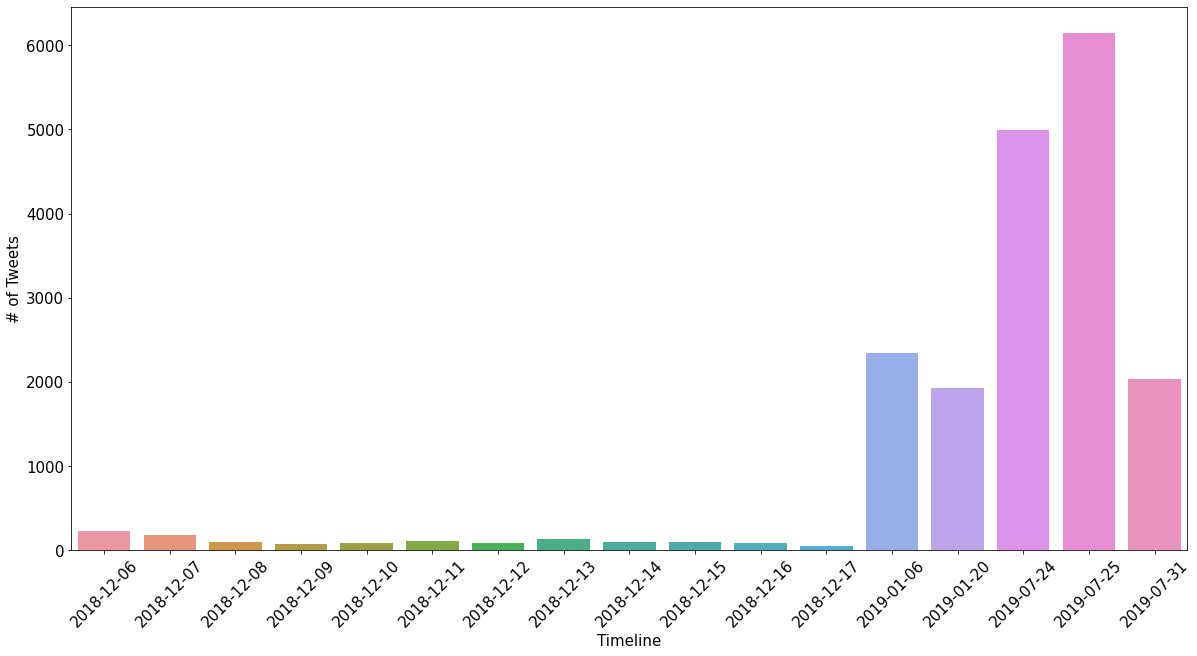

In [ ]:
#Visualizing the sample of tweets throughout time
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.barplot(x='y-m-d', y='tweet', data=tweets_timeline, ax=axis)
# ax.set_xticks(tweets_timeline['y-m-d'][::2])
ax.set_xticklabels(tweets_timeline['y-m-d'], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Timeline', fontsize=15)
ax.set_ylabel('# of Tweets', fontsize=15)

#### <span style="color:Red"><div style="text-align: justify">The results above is not conclusive at all because the data is incomplete *(STILL FETCHING)* its just an example to show the processing/fetching/wrangling pipeline. Also, fetching the data would be ta bit time consuming because we only have limit of 180 tweets per 15 min. Accordingly, we will be processing this in parallel.</div></span>

---

### <span style="color:green">B- Traumatic Events Dataset</span>

#### <span style="color:magenta">Web Scraping</span>

#### <span style="color:Purple"><div style="text-align: justify">We then looked at the literature to check how these analyses were carried out in publiched research. In both Ghosh 2020 and Kaufman 2021, the considered events were seemingly picked from the news coverage of the studied period. We set off to do the same. In our final list of traumatic events we will therefore present a selection of allegations of sexual misconduct extracted from the above mentioend papers, integrated with more updated lists such as [this](https://www.vox.com/a/sexual-harassment-assault-allegations-list?__c=1).</div></span>

#### <span style="color:Purple"><div style="text-align: justify"> Additionally, we also scraped the [website](https://www.vox.com/a/sexual-harassment-assault-allegations-list?__c=1) mentioned above since the WikiData is not sufficient in order to get the dates of alligations.

#### <span style="color:red"><div style="text-align: justify"> NOTE: The details of the web scraping is mentioned in **Impact_Score.ipynb**.

#### <span style="color:Purple"><div style="text-align: justify">Sources: [Ghosh, 2020](https://journals.sagepub.com/doi/abs/10.1177/1940161220968081) and [Kaufman, 2021](https://journals.sagepub.com/doi/abs/10.1177/0886260519868197)

In [ ]:
#Scrape the text of this URL
URL = "https://www.vox.com/a/sexual-harassment-assault-allegations-list?__c=1"
html = urlopen(URL).read()
soup = BeautifulSoup(html, features="html.parser")

#Kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

#Get text
text = soup.get_text()

#Break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
#Break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
#Drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)
#Split the texts based on the headlines in the website
print(text.split('/ 101')[1])


Frankie Shaw
Creator and star, Showtime's SMILF
Publicly reported
December 17, 2018
Multiple staffers have said she mishandled sex scenes, and one says she took off her own shirt in a dispute over onscreen nudity.
Sources/more info:
1
1 


In [ ]:
#Another example of extracted data
print(text.split('/ 101')[4])


“I have no shame for what was done to me. I am not the one who needs to carry that shame.”
Paige Carnes, who reported that Striegel abused her
Gerard Depardieu
Actor
Publicly reported
August 30, 2018
An actress has said he raped her. French authorities are investigating.
Sources/more info:
1
2
4 


---

### <span style="color:green">C- Non-Traumatic Events Dataset</span>

#### <span style="color:Purple"><div style="text-align: justify"> We had a very hard time finding dataset for non-traumatic events. Accordingly, we created our own data based on movie releases, related events and demonstrations.

#### <span style="color:magenta">1- Movie Releases</span>

In [ ]:
movies = {
    'Name':  ['Bombschell', 'Athlete A', 'On the record', 'The assistant', 'The tale', 'The invisible man', 'Promising young women', 'Unbelievable'],
    'Year': ['2019', '2020', '2020', '2019', '2018', '2020', '2020', '2019'],
    'Month':  ['12', '6','5', '10', '9', '2', '1', '9'],
    'Day': ['13', '24', '27', '13', '9','28', '25', '13'],
    'Country': ['USA', 'USA', 'USA', 'USA', 'USA', 'Australia', 'USA', 'USA']
        }
movies = pd.DataFrame(movies)
movies['nature']='movie'
movies

,Name,Year,Month,Day,Country,nature
0,Bombschell,2019,12,13,USA,movie
1,Athlete A,2020,6,24,USA,movie
2,On the record,2020,5,27,USA,movie
3,The assistant,2019,10,13,USA,movie
4,The tale,2018,9,9,USA,movie
5,The invisible man,2020,2,28,Australia,movie
6,Promising young women,2020,1,25,USA,movie
7,Unbelievable,2019,9,13,USA,movie


#### <span style="color:magenta">2- Events/Demonstrations</span>

In [ ]:
demonstrations = {
    'Name':  ['MeToo Survivors March', 'Womens March', 'Second Womens March'],
    'Year': ['2017', '2017', '2018'],
    'Month':  ['11', '11','1'],
    'Day': ['12', '21', '20'],
    'Country': ['USA', 'USA', 'USA'],
    'City': ['Los Angeles', 'Washington DC', 'Washington DC']
        }
demonstrations = pd.DataFrame(demonstrations)
demonstrations['nature']='demonstrations'
demonstrations

,Name,Year,Month,Day,Country,City,nature
0,MeToo Survivors March,2017,11,12,USA,Los Angeles,demonstrations
1,Womens March,2017,11,21,USA,Washington DC,demonstrations
2,Second Womens March,2018,1,20,USA,Washington DC,demonstrations


In [ ]:
#Other events
others = {
    'Name':  ['Weinstein fired by the Weinstein company', 'Alissa Mialno encourages people to share their stories of sexual harassment on twitter', 'Publication of "Good and Mad" speaking of the revolutionnary power of womens anger'],
    'Year': ['2017', '2017', '2018'],
    'Month':  ['10', '10','10'],
    'Day': ['8', '16', '2'],
        }
others = pd.DataFrame(others)
others['nature']='others'
others

,Name,Year,Month,Day,nature
0,Weinstein fired by the Weinstein company,2017,10,8,others
1,Alissa Mialno encourages people to share their...,2017,10,16,others
2,"Publication of ""Good and Mad"" speaking of the ...",2018,10,2,others


In [ ]:
#Concatenate all results
concatenation = pd.concat([movies, demonstrations, others],  axis=0).sort_values(by=['Year','Month'], ascending = [True, True])
concatenation

,Name,Year,Month,Day,Country,nature,City
0,Weinstein fired by the Weinstein company,2017,10,8,NaN,others,NaN
1,Alissa Mialno encourages people to share their...,2017,10,16,NaN,others,NaN
0,MeToo Survivors March,2017,11,12,USA,demonstrations,Los Angeles
1,Womens March,2017,11,21,USA,demonstrations,Washington DC
2,Second Womens March,2018,1,20,USA,demonstrations,Washington DC
2,"Publication of ""Good and Mad"" speaking of the ...",2018,10,2,NaN,others,NaN
4,The tale,2018,9,9,USA,movie,NaN
3,The assistant,2019,10,13,USA,movie,NaN
0,Bombschell,2019,12,13,USA,movie,NaN
7,Unbelievable,2019,9,13,USA,movie,NaN


---

### <span style="color:green">D- Meta Dataset</span>

#### <span style="color:Purple"><div style="text-align: justify">Here, we explore the meta data provided to use for the inference phase in which we could use the demographic features of the speaker as features to train a model to predict the impact of a quotes related to MeToo.</div></span>

In [ ]:
#Load metadata
df_metadata = pd.read_parquet('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/speaker_attributes.parquet')

In [ ]:
#Loading the manual extracted quotes
keywords_extracted_data_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/keywords-extracted-data.csv.bz2'
keywords_extracted_data = glob.glob(keywords_extracted_data_path)
keywords_extracted_data

['/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/keywords-extracted-data.csv.bz2']

In [ ]:
#Cleaning df_medata from duplicates
clean = df_metadata.drop_duplicates(subset='label', keep=False)

In [ ]:
#process the merge between clean metadata dataframe and manual extracted quotes
def process_chunk(chunk):
  merge = pd.merge(chunk, clean, how='inner',left_on='speaker', right_on='label' )
  return merge

total_size=0

for dataset in keywords_extracted_data:
  df_reader = pd.read_csv(dataset, compression='bz2', chunksize=500000)
  print(f'Processing with {dataset}')
  for chunk in df_reader:
      print(f'Processing chunk with {len(chunk)} rows')
      merge = process_chunk(chunk.replace(to_replace='None', value=np.nan).dropna(subset=['speaker']))
      merge.to_csv(path_or_buf='/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/extraction_known_speakers.csv.bz2', compression='bz2', mode='a')
      total_size+=len(merge)

Processing with /content/drive/Shareddrives/ADA LUNATICS 2021/datasets/keywords-extracted-data.csv.bz2
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 500000 rows
Processing chunk with 125941 rows


In [ ]:
print(f'the number of manually extracted quotes with a speaker mentioned in the dataset: {total_size}')

the number of manually extracted quotes with a speaker mentioned in the dataset: 2566225


---